In [4]:
# 通过多项式拟合来交互地探索这些概念
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
# 使用三阶多项式来生成训练和测试数据的标签
# y = 5 + 1.2x - 3.4 * x^2 / 2! + 5.6 * x^3 / 3! + e where e ~ N(0, 0.01^2)
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [6]:
# 看一下前两个样本
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32) for x in (true_w, features, poly_features, labels)
]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.1991],
         [-0.4236]]),
 tensor([[ 1.0000e+00,  1.9908e-01,  1.9816e-02,  1.3150e-03,  6.5446e-05,
           2.6058e-06,  8.6459e-08,  2.4589e-09,  6.1188e-11,  1.3535e-12,
           2.6945e-14,  4.8764e-16,  8.0899e-18,  1.2389e-19,  1.7617e-21,
           2.3380e-23,  2.9091e-25,  3.4067e-27,  3.7677e-29,  3.9478e-31],
         [ 1.0000e+00, -4.2361e-01,  8.9724e-02, -1.2669e-02,  1.3417e-03,
          -1.1367e-04,  8.0256e-06, -4.8568e-07,  2.5717e-08, -1.2105e-09,
           5.1277e-11, -1.9747e-12,  6.9708e-14, -2.2715e-15,  6.8730e-17,
          -1.9410e-18,  5.1389e-20, -1.2805e-21,  3.0136e-23, -6.7189e-25]]),
 tensor([4.9824, 4.0627]))

In [7]:
# 实现一个函数来评估模型在给定数据集上的损失
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [8]:
# 定义训练函数
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9933033  1.1833811 -3.4001553  5.6086326]]


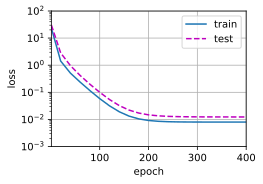

In [9]:
# 三阶多项式函数拟合（正态）
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[3.2361312 4.3141565]]


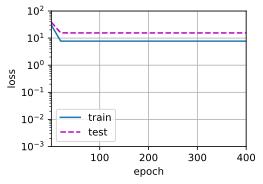

In [10]:
# 线性函数拟合（欠拟合）
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9747815   1.2566309  -3.3184803   5.192787   -0.29939964  1.2330779
   0.22654986  0.20798656 -0.07174446  0.14829324  0.0476593  -0.20631117
  -0.19150333 -0.10411184  0.1485457   0.12739101  0.04570804 -0.0126363
   0.13668299 -0.14235279]]


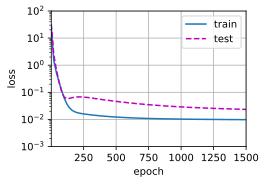

In [11]:
# 高阶多项式函数拟合
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)